In [1]:
import os
import sys
import glob
import xarray as xr
import numpy as np
from scipy.stats import genextreme, weibull_min
from joblib import Parallel, delayed
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

operating_system = 'curnagl'

if operating_system == 'win':
    os.chdir('C:/Users/fabau/OneDrive/Documents/GitHub/master-project-cleaned/')
elif operating_system == 'curnagl':
    os.chdir('/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/cleaner_version/')
else:
    os.chdir('/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/')

# Add the path to the custom library
custom_library_path = os.path.abspath('util/processing/')
sys.path.append(custom_library_path)

import time_series

custom_library_path_2 = os.path.abspath('util/gev')
sys.path.append(custom_library_path_2)

import data_processing
from data_processing import depickle, save_to_pickle

In [2]:
# Prepare data for processing
tif_15 = xr.open_dataset('pre_processing/cluster/number_of_clusters/cleaned_cluster_15_v2.tif', engine='rasterio')
tif_15 = tif_15.rename({'x': 'longitude', 'y': 'latitude'})

#path = '/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/data/time_series_rasters_storms_15h/'
cluster_csv = 'pre_processing/cluster/number_of_clusters/cleaned_cluster_15_v2.csv'
months = [10, 11, 12, 1, 2, 3]  # Winter months
days = range(1, 32)  # Days from 01 to 31

In [4]:
# TAKES 17 MINUTES TO RUN
without_storms = ''

def initialize_datasets_winter(months, days):
    datasets_winter = []
    for month in months:
        for day in days:
            try:
                dataset = depickle(f'data/climatology/hourly_winter_season/climatology_europe_winter_{month}_{day}.pkl')
                datasets_winter.append(dataset)
            except FileNotFoundError:
                print(f'No data for month {month} and day {day}')
    return datasets_winter

# Load cluster data
cluster_data_original = pd.read_csv(cluster_csv)

# Initialize datasets_winter
datasets_winter = initialize_datasets_winter(months, days)

No data for month 11 and day 31
No data for month 2 and day 30
No data for month 2 and day 31


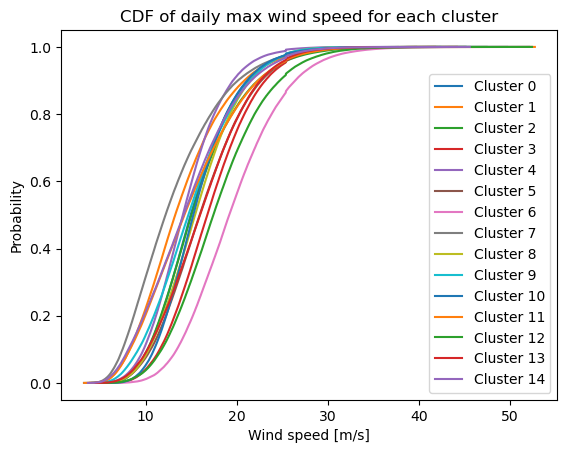

In [11]:
#def process_storm_file(event, cluster_data_original, datasets_winter, tif_15):
#print(f"Processing event: {event}")

hourly = 'yes'
hours = range(0, 24)

clusters = range(0, 15)

for cluster_n in clusters:
    dataset_wind_speed = []
    for dataset in datasets_winter:
        for ds in dataset:
            ds_cluster = ds.where(tif_15['band_data'] == cluster_n)
            if hourly == 'yes':
                for hour in hours:
                    ds_hour = ds_cluster.sel(time=ds_cluster['time.hour'] == hour)
                    hourly_max = ds_hour['i10fg'].max().values
                    dataset_wind_speed.append(hourly_max)
            else:
                daily_max = ds_cluster['i10fg'].max().values
                dataset_wind_speed.append(daily_max)
    dataset_wind_speed = np.array(dataset_wind_speed)
    
    # plot the cdf
    dataset_wind_speed.sort()
    ecdf_x = ECDF(dataset_wind_speed).x
    ecdf_y = ECDF(dataset_wind_speed).y
    ecdf_x = ecdf_x[1:]
    ecdf_y = ecdf_y[1:]

    # save the ECDF
    pd.DataFrame(ecdf_y).to_csv(f'data/climatology_hm_winter_per_cluster{without_storms}/ECDF/ECDF_cluster_{cluster_n}.csv')

    # save the dataset_wind_speed
    pd.DataFrame(dataset_wind_speed).to_csv(f'data/climatology_hm_winter_per_cluster{without_storms}/wind_data_cluster_{cluster_n}.csv')

    print(f'Cluster {cluster_n} done')

    plt.plot(ecdf_x, ecdf_y, label=f'Cluster {cluster_n}')

plt.legend()
plt.title('CDF of daily max wind speed for each cluster')
plt.xlabel('Wind speed [m/s]')
plt.ylabel('Probability')
plt.show()